In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from scipy import stats
from scipy import signal
from scipy.spatial.distance import euclidean

from sklearn.model_selection import train_test_split

In [16]:
ecgs = np.loadtxt("ecg.csv", delimiter=",")

In [17]:
X, y = ecgs[:,:-1], ecgs[:, -1]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [13]:
np.unique(y_test, return_counts=True)

(array([0., 1.]), array([408, 592], dtype=int64))

### Unbiased Variance

In [49]:
stats.tvar(X_train[0])

1.0000000027371407

In [20]:
def unbiased_var(ts):
    mean = ts.mean()
    N = len(ts)
    return ((ts-mean)**2).sum()/(N-1)

In [21]:
unbiased_var(X_train[0])

1.0000000027371407

In [57]:
ecg_neg = np.array(list(map(unbiased_var, X_train[y_train==0])))
ecg_neg.mean(), ecg_neg.std()

(1.0000000000106128, 4.4183772525699564e-09)

In [56]:
ecg_pos = np.array(list(map(unbiased_var, X_train[y_train==1])))
ecg_pos.mean(), ecg_pos.std()

(0.9999999998953338, 4.376717097350575e-09)

No major differences when using unbiased variance

### Stationary Average

In [36]:
def stat_av(ts, wsize=10):
    windows = np.concatenate([
        ts[i:i+wsize].reshape(1, -1) for i in range(0, len(ts)-wsize, wsize)
    ])
    windows_mean=windows.mean(axis=1)
    return windows.std() / ts.std()

In [208]:
ecg_neg = np.array(list(map(lambda x: stat_av(x, 10), X_train[y_train==0])))
ecg_neg.mean(), ecg_neg.std()

(0.7388373774143807, 0.13877193858522335)

In [209]:
ecg_pos = np.array(list(map(lambda x: stat_av(x, 10), X_train[y_train==1])))
ecg_pos.mean(), ecg_pos.std()

(0.9814639840907462, 0.031065589103469963)

(0.11357571211587675, 1.1374435465414394)

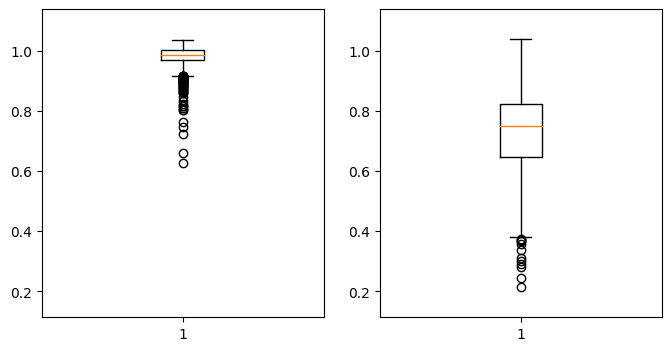

In [210]:
f,ax  = plt.subplots(1,2, figsize=(8,4))
low, high = min(ecg_pos.min(), ecg_neg.min()) - 0.1, max(ecg_pos.max(), ecg_neg.max()) +0.1
ax[0].boxplot(ecg_pos);
ax[0].set_ylim(low,high)
ax[1].boxplot(ecg_neg);
ax[1].set_ylim(low,high)

We can see that this global feature may already separate a few of the classes

### Autocorrelation

In [42]:
def autocorrelation(ts, lag):
    N = len(ts)
    mean = ts.mean()
    
    return ((ts[:-lag] - mean) * (ts[lag:] - mean)).sum() / (unbiased_var(ts) * (N - lag))

In [41]:
autocorrelation(X_train[0], 10)

0.05629236270173407

In [48]:
np.correlate(X_train[0, :-10], X_train[0, 10:]) / (unbiased_var(X_train[0]) * 130)

array([0.05629236])

In [85]:
best = None
max_dist = -1
for lag in range(1, 25):
    ecg_neg = np.array(list(map(lambda x: autocorrelation(x,lag), X_train[y_train==0])))
    ecg_pos = np.array(list(map(lambda x: autocorrelation(x,lag), X_train[y_train==1])))

    dist = euclidean(
        np.array([ecg_neg.mean(), ecg_neg.std()]),
        np.array([ecg_pos.mean(), ecg_pos.std()])
    )
    if dist > max_dist:
        best = lag
        max_dist = dist

In [86]:
best

24

In [87]:
ecg_neg = np.array(list(map(lambda x: autocorrelation(x, best), X_train[y_train==0])))
ecg_pos = np.array(list(map(lambda x: autocorrelation(x, best), X_train[y_train==1])))

In [88]:
ecg_neg.mean(), ecg_neg.std()

(-0.05465197459033898, 0.11672098874877967)

In [89]:
ecg_pos.mean(), ecg_pos.std()

(0.2560348291427112, 0.12315647895669421)

(-0.6754801860936801, 0.6895186345359028)

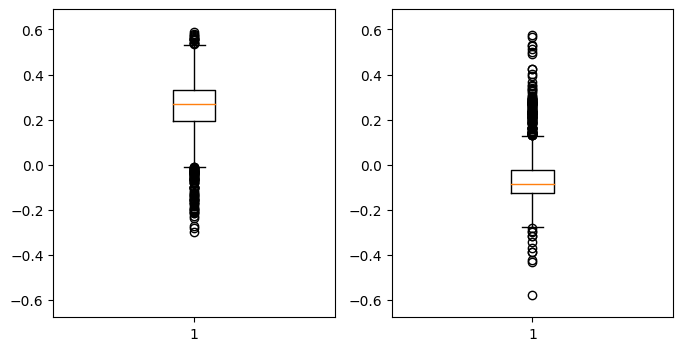

In [90]:
f,ax  = plt.subplots(1,2, figsize=(8,4))
low, high = min(ecg_pos.min(), ecg_neg.min()) - 0.1, max(ecg_pos.max(), ecg_neg.max()) +0.1
ax[0].boxplot(ecg_pos);
ax[0].set_ylim(low,high)
ax[1].boxplot(ecg_neg);
ax[1].set_ylim(low,high)

Although not as clear, we can see some differences between the two classes with autocorrelation

### Aproximate Entropy

### Using global features to predict ecg "normal" vs "abnormal"

In [223]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, matthews_corrcoef

In [219]:
def to_feat_vec(X):
    X = np.concatenate((
        np.array(list(map(stat_av, X))).reshape(-1,1),
        np.array(list(map(lambda x: autocorrelation(x, 24), X))).reshape(-1,1)
    ), axis=1)
    
    return X

In [221]:
lr = LogisticRegression().fit(to_feat_vec(X_train), y_train)
lr.score(to_feat_vec(X_train), y_train)

0.935967983991996

In [222]:
lr.score(to_feat_vec(X_test), y_test)

0.926

In [224]:
preds = lr.predict(to_feat_vec(X_test))

In [226]:
print(matthews_corrcoef(y_test,preds))
print(classification_report(y_test,preds))

0.8478483882896178
              precision    recall  f1-score   support

         0.0       0.96      0.86      0.90       408
         1.0       0.91      0.97      0.94       592

    accuracy                           0.93      1000
   macro avg       0.93      0.92      0.92      1000
weighted avg       0.93      0.93      0.93      1000



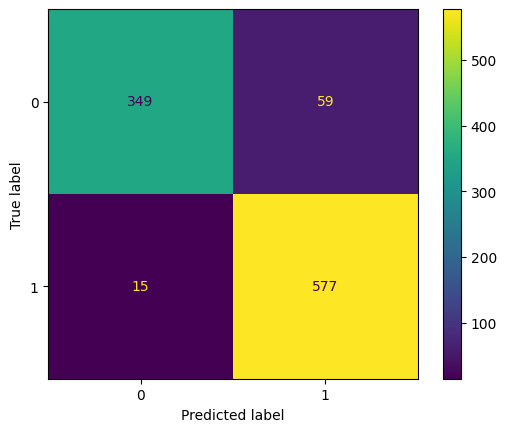

In [227]:
ConfusionMatrixDisplay(
    confusion_matrix(y_test,preds)
).plot()

With only 2 global features we could fit a simple *Logistic Regression* model that obtained very good results for binary *ECG* classification.